<a href="https://colab.research.google.com/github/zz-carol/zijingzhou_website/blob/main/school_project/python/cs325/Another_copy_of_HW5_Fine_Tuning_BERT_Classification_CS325.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and Fine-Tuning BERT for Classification

Original version: By Maria Antoniak, Melanie Walsh, and the [AI for Humanists](https://aiforhumanists.com/) Team

Modified for Emory CS325 by Eugene Agichtein 4/21/2025

Updated: 4/27/2025: Specified modifications for experiments
Updated: 4/22/2025: added external LLM baseline


We will fine-tune a BERT model on Goodreads reviews from the [UCSD Book Graph](https://mengtingwan.github.io/data/goodreads.html) with the goal of predicting the genre of the book being reviewed. The genres include:
- poetry
- comics & graphic
- fantasy & paranormal
- history & biography
- mystery, thriller, & crime
- romance
- young adult  

**Basic steps involved in using BERT and HuggingFace:**
1. Divide your data into training and test sets.
2. Encode your data into a format BERT will understand.
3. Combine your data and labels into dataset objects.
4. Load the pre-trained BERT model.
5. **Fine-tune the model using your training data.**
6. Predict new labels and evaluate performance on your test data.

**Your Fine-tuning Experiments**
1. Experiment with classifier structure: Number of layers, number of neurons, activation, dropout, etc
2. Freeze or update underlying transformer layers?
3. Hyper-parameters: learning rate, model checkpoints, early stopping.

** Grading/evaluation criteria **
* 61% test accuracy: full credit (match performance of default model provided, see code below).
* >= 60%: 8/10
* > 61% test accuracy: +5pts extra credit.




<br><br>

## **Import necessary Python libraries and modules**

First, we will import necessary Python libraries and modules. These include as `gdown`, for downloading large files from Google Drive (where we will get our UCSD Goodreads reviews), as well as scikit-learn (`sklearn`) and PyTorch (`torch`), for various machine learning tools.

In [ ]:
# Basic Python modules
from collections import defaultdict
import random
import pickle

# For downloading large files from Google Drive
# https://github.com/wkentaro/gdown
import gdown

# For working with gzip files
# https://docs.python.org/3/library/gzip.html
import gzip

# For working with JSON files
import json

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For machine learning tools and evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# For deep learning
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch
import os

print(f"Number of available GPUs: {torch.cuda.device_count()}")
print(f"Is CUDA available? {torch.cuda.is_available()}")

# For plotting and data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

Number of available GPUs: 1
Is CUDA available? True


The HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html) is included in Colab by default now, so we do not need to install it (but this is how you would install it with `pip`).

In [ ]:
#!pip3 install transformers

From `transformers`, we will import modules for `DistilBert`, a *distilled* or smaller version of a BERT model that runs more quickly and uses less computing power. This makes it ideal for those just getting started with BERT.

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

<br><br>

## **Set parameters and file paths**

In [ ]:
# This is the name of the BERT model that we want to use.
# We're using DistilBERT to save space (it's a distilled version of the full BERT model),
# and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'

# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'distilbert-reviews-genres'

<br><br>

## **Load and sample Goodreads data**

In this cell, we create a Python dictionary with each genre and the link to the corresponding UCSD Goodreads review data for that genre.

*If you manually click on any of the URLs, you will be able to download the data for that genre. For example, here's the link for poetry: https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/goodreads_reviews_poetry.json.gz*

In [ ]:
# This is where our target data is hosted on the web. You only need these paths for the book review dataset.

# Source: https://mengtingwan.github.io/data/goodreads.html#datasets
#https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_books_children.json.gz

genre_url_dict = {'poetry':                 'https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_reviews_poetry.json.gz',
                  'children':               'https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_reviews_children.json.gz',
                  'comics_graphic':         'https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_reviews_comics_graphic.json.gz',
                  'fantasy_paranormal':     'https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_reviews_fantasy_paranormal.json.gz',
                  'history_biography':      'https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_reviews_history_biography.json.gz',
                  'mystery_thriller_crime': 'https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_reviews_mystery_thriller_crime.json.gz',
                  'romance':                'https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_reviews_romance.json.gz',
                  'young_adult':            'https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre/goodreads_reviews_young_adult.json.gz'
                  }

Next we loop through this dictionary and use `gdown` to download the Goodreads review data for each genre from Google Drive.

Now we will load the first 100,000 reviews from each link and randomly sample 2,000 reviews.

In [ ]:
import requests
# Stream reviews from URL and collect a subset
def load_reviews(url, head=10000, sample_size=2000):
    reviews = []
    count = 0

    response = requests.get(url, stream=True)
    print(f'Downloading reviews from {url}')
    with gzip.open(response.raw, 'rt', encoding='utf-8') as file:
        for line in file:
            d = json.loads(line)
            reviews.append(d['review_text'])
            count += 1

            # Stop if we have reached the 100,000 limit
            if head is not None and count >= head:
                break

    # Return random sample of reviews
    return random.sample(reviews, min(sample_size, len(reviews)))

# Reviews by genre
genre_reviews_dict = {}

# Load reviews for each genre
for genre, url in genre_url_dict.items():
    print(f'Loading reviews for genre: {genre}')
    genre_reviews_dict[genre] = load_reviews(url, head=10000, sample_size=2000)


Loading reviews for genre: poetry
Loading reviews for genre: children
Loading reviews for genre: comics_graphic
Loading reviews for genre: fantasy_paranormal
Loading reviews for genre: history_biography
Loading reviews for genre: mystery_thriller_crime
Loading reviews for genre: romance
Loading reviews for genre: young_adult


Let's preview a couple of the key-value pairs in `genre_reviews_dict`

In [ ]:
 for _genre, _reviews in genre_reviews_dict.items():
    print(_genre)
    print(random.sample(_reviews, 1)[0])

poetry
Read Me is a collection of poems for parents and children to read together over the course of a year. Each poem is assigned a date and the subjects covered are on topic for their date. 
 The book includes well known poems like Elizabeth Barrett Browning's "How Do I Love Thee" (February 15) and "In Flanders Fields" by John McCrae (August 12). It also has a large number of nursery rhymes and hymns such as "Simple Simon" (May 30) and "O Little Town" by Bishop Phillips Brooks (December 25). Mostly though the poems are playful and unusual. 
 Someone better versed in children's poetry will recognize more of the selections than I did. I though enjoyed finding so many surprises tucked away in this 470 page volume. 
 The only disappoint for me was December. Too much of the month is focused on Christmas carols. The book comes to a ho-hum close. I understand that Christmas (especially in a British book) would be the main focus for December but I would have preferred to see the same level o

Here we use `pickle` to save this Python dictionary to a `.pickle` file so we can easily load it later.

*The `pickle` module allows you to save and load Python objects like lists and dictionaries.*

In [ ]:
pickle.dump(genre_reviews_dict, open('genre_reviews_dict.pickle', 'wb'))
# genre_reviews_dict = pickle.load(open('genre_reviews_dict.pickle', 'rb'))

<br><br>

## **Split the data into training and test sets**

When training a machine learning model, it is necessary to split your training data into two parts: a "training" set and a "test" set.

We will train our BERT model on the "training" set of Goodreads reviews and then we will evaluate how well it is performing by running it on the "test" set of Goodreads reviews that the model has never seen before.

Normally, to tune the hyperparameters, you should also create a "validation" set for tuning, and only use the "test" set once, at the end of all tuning. For simplicity, in this tutorial, we will only using a training and test set.

In [ ]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

for _genre, _reviews in genre_reviews_dict.items():

  _reviews = random.sample(_reviews, 1000) # Use a very small set as an example.

  for _review in _reviews[:800]:
    train_texts.append(_review)
    train_labels.append(_genre)
  for _review in _reviews[800:]:
    test_texts.append(_review)
    test_labels.append(_genre)

Show how many Goodreads reviews and labels we have in each category: 6400 training reviews, 6400 training labels (genres), 1600 test reviews, 1600 test labels (genre)

In [ ]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(6400, 6400, 1600, 1600)

Here's an example of a training label and review:

In [ ]:
train_labels[1], train_texts[1]

('poetry',
 "Mothers are so often ignored and taken for granted all the very deep and amazing things they do. Maya Angelou has wonderfully dug deep within herself to think about the interesting push and pull of the mother psyche and presence in a child's life. This poem book is a very nice homage to her mother.")

<br><br>

## **Encode data for BERT**

We're going to transform our texts and labels into a format that BERT (via Huggingface and PyTorch) will understand. This is called *encoding* the data.

Here are the steps we need to follow:

1. The labels&mdash;in this case, Goodreads genres&mdash;need to be turned into integers rather than strings.

2. The texts&mdash;in this case, Goodreads reviews&mdash;need to be truncated if they're more than 512 tokens or padded if they're fewer than 512 tokens. The tokens, or words in the texts, also need to be separated into "word pieces" and matched to their embedding vectors.

3. We need to add special tokens to help BERT:

| BERT special token | Explanation |
| --------------| ---------|
| [CLS] | Start token of every document. |
| [SEP] | Separator between each sentence |
| [PAD] | Padding at the end of the document as many times as necessary, up to 512 tokens |
|  &#35;&#35; | Start of a "word piece" |




Here we will load `DistilBertTokenizerFast` from the HuggingFace library, which will do all the work of encoding the texts for us. The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

Here we will create a map of our labels, or Goodreads genres, to integer keys. We take the unique labels, and then we make a dictionary that associates each label/tag with an integer.

**Note:** HuggingFace documentation sometimes refers to "labels" as "tags" but these are the same thing. We use "labels" throughout this notebook for clarity.

In [ ]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
label2id.keys()

dict_keys(['mystery_thriller_crime', 'romance', 'young_adult', 'children', 'comics_graphic', 'history_biography', 'fantasy_paranormal', 'poetry'])

In [ ]:
id2label.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

Now let's encode our texts and labels!

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

**Examine a Goodreads review in the training set after encoding**

In [ ]:
' '.join(train_encodings[1].tokens[0:100])

"[CLS] Mother ##s are so often ignored and taken for granted all the very deep and amazing things they do . Maya Angelo ##u has wonderful ##ly dug deep within herself to think about the interesting push and pull of the mother ps ##ych ##e and presence in a child ' s life . This poem book is a very nice homage to her mother . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

**Examine a Goodreads review in the test set after encoding**

In [ ]:
' '.join(test_encodings[1].tokens[0:100])

'[CLS] Hz ##yn w ##bs ##y ##T [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

**Examine the training labels after encoding**

In [ ]:
set(train_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

**Examine the test labels after encoding**

In [ ]:
set(test_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

<br><br>

## **Make a custom dataset for BERT using Torch **

Here we combine the encoded labels and texts into dataset objects. We use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `test_dataset` object from `test_encodings`, and `test_labels_encoded`.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

**Examine a Goodreads review in the Torch `training_dataset` after encoding**

In [ ]:
' '.join(train_dataset.encodings[1].tokens[0:100])

"[CLS] Mother ##s are so often ignored and taken for granted all the very deep and amazing things they do . Maya Angelo ##u has wonderful ##ly dug deep within herself to think about the interesting push and pull of the mother ps ##ych ##e and presence in a child ' s life . This poem book is a very nice homage to her mother . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

**Examine a Goodreads review in the Torch `test_dataset` after encoding**

In [ ]:
' '.join(test_dataset.encodings[1].tokens[0:100])

'[CLS] Hz ##yn w ##bs ##y ##T [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

<br><br>

## **Create classifier from pre-trained BERT model representation**

Here we load a pre-trained DistilBERT model and send it to CUDA.

**Note:** If you decide to repeat fine-tuning after already running the following cells, make sure that you re-run this cell to re-load the original pre-trained model before fine-tuning again.

In [ ]:
# The model_name needs to match the name used for the tokenizer above.
default_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# YOUR WORK STARTS HERE:  Define your custom version of DistillBertClassifier
** Your code will be below **
Things you will experiment with:

*  Structure of the classifier layer on top of BERT embeddings
*  Which layers are optimized (fine-tuned) vs. frozen (see code below)
*  Hyperparameters for training in training arguments



In [ ]:
import torch.nn as nn
num_labels = len(id2label)
#https://machinelearningmastery.com/best-practices-document-classification-deep-learning/
class myDistilBertForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        # Add custom linear layers here
        self.custom_classifier = nn.Sequential(
            # nn.Linear(config.hidden_size, config.num_labels),  # One layer
            #*** your code here
            nn.Linear(config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, config.num_labels)
        )

        #required to invoke your custom classifier after BERT encoding
        def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
          hidden_states = super().forward(input_ids, attention_mask, **kwargs).hidden_states
          pooled_output = hidden_states[-1][:, 0]  # Use the last hidden state
          #your classifier runs on top of the BERT hidden state output for the sequence
          logits = self.custom_classifier(pooled_output)
          return logits



In [ ]:
my_model = myDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of myDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'custom_classifier.0.bias', 'custom_classifier.0.weight', 'custom_classifier.3.bias', 'custom_classifier.3.weight', 'custom_classifier.6.bias', 'custom_classifier.6.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define which layers of BERT embeddings to update
By default - all embedding layers are frozen. Sometimes helpful to fine-tune last transformer layer

In [ ]:
#define which layers get updated
embedding_module = my_model.distilbert.embeddings

# Set all layers in embedding module to not be trainable - consider un-freezing some of them.
embedding_module.requires_grad_(False)
#unfreeze some of these?
embedding_module.word_embeddings.requires_grad=False
embedding_module.position_embeddings.requires_grad=False
embedding_module.dropout.requires_grad=False

In [ ]:
# Unfreeze last transformer layer and layernorm
for param in my_model.distilbert.transformer.layer[-1].parameters():
    param.requires_grad = True

# Also unfreeze the final layer norm (useful in DistilBERT)
for param in my_model.distilbert.transformer.layer[-1].output_layer_norm.parameters():
    param.requires_grad = True

In [ ]:
# Unfreeze the last two layers of DistilBERT
for layer in my_model.distilbert.transformer.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True


<br><br>

## **Set the BERT fine-tuning parameters**

These are the arguments we'll set in the HuggingFace TrainingArguments objects, which we'll then pass to the HuggingFace Trainer object. There are many more possible arguments, but here we highlight the basics and some common gotchas.

When training your own model, you should search over these parameters to find the best settings for your particular dataset. You should use a held-out set of validation data for this step.

| Parameter | Explanation |
|-----------| ------------|
| num_train_epochs | total number of training epochs (how many times to pass through the entire dataset; too much can cause overfitting) |
| per_device_train_batch_size | batch size per device during training |
| per_device_eval_batch_size |  batch size for evaluation |
|  warmup_steps |  number of warmup steps for learning rate scheduler (set lower because of small dataset size) |
| weight_decay | strength of weight decay (reduces size of weights, like regularization) |
| output_dir | output directory for the fine-tuned model and configuration files |
| logging_dir | directory for storing logs |
| logging_steps | how often to print logging output (so that we can stop training early if the loss isn't going down) |
| evaluation_strategy | evaluate while training so that we can see the accuracy going up |

In [ ]:
# training_args = TrainingArguments(
#     num_train_epochs=3,              # total number of training epochs
#     per_device_train_batch_size=16,  # batch size per device during training
#     per_device_eval_batch_size=40,   # batch size for evaluation
#     learning_rate=1e-4,              # initial learning rate for Adam optimizer
#     warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
#     weight_decay=0.01,               # strength of weight decay
#     output_dir='./results',          # output directory
#     logging_dir='./logs',            # directory for storing logs
#     logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
#     eval_strategy='steps',            # evaluate during fine-tuning so that we can see progress
#     report_to=[],                     # Disables wandb logging
#     save_strategy='steps',
#     save_steps=100,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy"
# )

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    warmup_steps=100,
    weight_decay=0.01,
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='steps',
    save_strategy='steps',
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=[]
)


<br><br>

## **Fine-tune the BERT model**

First, we define a custom evaluation function that returns the accuracy. You could modify this function to return precision, recall, F1, and/or other metrics.

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

Then we create a HuggingFace `Trainer` object using the `TrainingArguments` object that we created above. We also send our `compute_metrics` function to the `Trainer` object, along with our test and train datasets.

**Note:** This is what we've been aiming for this whole time! All the work of tokenizing, creating datasets, and setting the training arguments was for this cell.

In [ ]:
#which model to tune?
model = my_model

if torch.cuda.device_count() > 1:
  model = torch.nn.DataParallel(model)
  print
  model.to('cuda')

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function
)

Time to finally fine-tune!

Be patient; if you've set everything in Colab to use GPUs, then it should only take a minute or two to run, but if you're running on CPU, it can take hours.

After every 10 steps (as we specified in the TrainingArguments object), the trainer will output the current state of the model, including the training loss, validation ("test") loss, and accuracy (from our `compute_metrics` function).

You should see the loss going down and the accuracy going up. If instead they are staying the same or oscillating, you probably need to change the fine-tuning parameters.

In [ ]:
# Turn off weights and biases logging, which requires an API key

import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,2.048900,1.882687,0.380000
200,1.658100,1.454884,0.499375
300,1.480600,1.367268,0.510000
400,1.325700,1.333014,0.545000
500,1.309200,1.223924,0.566250
600,1.280900,1.234954,0.559375
700,1.320600,1.198506,0.566250
800,1.269700,1.173778,0.583125
900,1.061900,1.179458,0.578125
1000,0.993700,1.175443,0.575000


TrainOutput(global_step=4000, training_loss=0.7933113360404969, metrics={'train_runtime': 2721.5276, 'train_samples_per_second': 11.758, 'train_steps_per_second': 1.47, 'total_flos': 4291227549696000.0, 'train_loss': 0.7933113360404969, 'epoch': 5.0})

<br><br>

## **Save fine-tuned model**

The following cell will save the model and its configuration files to a directory in Colab. To preserve this model for future use, you should download the model to your computer.

In [ ]:
trainer.save_model(cached_model_directory_name)

(Optional) If you've already fine-tuned and saved the model, you can reload it using the following line. You don't have to run fine-tuning every time you want to evaluate.

In [ ]:
trainer.model = myDistilBertForSequenceClassification.from_pretrained(cached_model_directory_name).to(device_name)

<br><br>

## **Evaluate fine-tuned model**

The following function of the `Trainer` object will run the built-in evaluation, including our `compute_metrics` function.

In [ ]:
trainer.evaluate()

{'eval_loss': 1.4490950107574463,
 'eval_accuracy': 0.61375,
 'eval_runtime': 22.5972,
 'eval_samples_per_second': 70.805,
 'eval_steps_per_second': 2.213,
 'epoch': 5.0}

But we might want to do more fine-grained analysis of the model, so we extract the predicted labels.

In [ ]:
predicted_results = trainer.predict(test_dataset)

In [ ]:
predicted_results.predictions.shape

(1600, 8)

In [ ]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [ ]:
len(predicted_labels)

1600

In [ ]:
print(classification_report(test_labels,
                            predicted_labels))

                        precision    recall  f1-score   support

              children       0.72      0.77      0.74       200
        comics_graphic       0.81      0.80      0.81       200
    fantasy_paranormal       0.40      0.47      0.43       200
     history_biography       0.62      0.62      0.62       200
mystery_thriller_crime       0.59      0.55      0.57       200
                poetry       0.81      0.77      0.79       200
               romance       0.62      0.57      0.59       200
           young_adult       0.38      0.36      0.37       200

              accuracy                           0.61      1600
             macro avg       0.62      0.61      0.62      1600
          weighted avg       0.62      0.61      0.62      1600




#default model
```
#the model to beat


                        precision    recall  f1-score   support

              children       0.71      0.68      0.70       200
        comics_graphic       0.80      0.78      0.79       200
    fantasy_paranormal       0.40      0.41      0.40       200
     history_biography       0.57      0.61      0.59       200
mystery_thriller_crime       0.59      0.54      0.56       200
                poetry       0.75      0.79      0.77       200
               romance       0.66      0.66      0.66       200
           young_adult       0.41      0.43      0.42       200

              accuracy                           0.61      1600
             macro avg       0.61      0.61      0.61      1600
          weighted avg       0.61      0.61      0.61      1600
```

#YOUR model results:

##model structure (copy/paste from your custom classifier below)
```
nn.Linear(config.hidden_size, 512),
nn.ReLU(),
nn.Dropout(0.4),
nn.Linear(512, 256),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(256, config.num_labels)
```

##your model test accuracy: (copy/paste the detailed results from above)

```
                        precision    recall  f1-score   support

              children       0.72      0.77      0.74       200
        comics_graphic       0.81      0.80      0.81       200
    fantasy_paranormal       0.40      0.47      0.43       200
     history_biography       0.62      0.62      0.62       200
mystery_thriller_crime       0.59      0.55      0.57       200
                poetry       0.81      0.77      0.79       200
               romance       0.62      0.57      0.59       200
           young_adult       0.38      0.36      0.37       200

              accuracy                           0.61      1600
             macro avg       0.62      0.61      0.62      1600
          weighted avg       0.62      0.61      0.62      1600

```





<br><br>

## **Pull out correct and incorrect classifications for examination**

Let's use our predicted labels for some analysis!

Now that we've fine-tuned and pulled out our predicted labels, the BERT part of this tutorial is done. You can now use the predicted labels in the same way you would use any set of predicted labels from any classification model. We'll show some examples here.

First, let's print out some example predictions that were correct.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: romance
REVIEW TEXT: This is the eighth book in a series, and can be enjoyed as a standalone. 
 Blake "Rolex" Raleigh is  ...

LABEL: children
REVIEW TEXT: The castle is my favorite "character," in this fun book. I can't wait to read this with my kids soon ...

LABEL: poetry
REVIEW TEXT: Saya tak tahu bagaimana harus mereview puisi, yang saya bisa hanya menikmati. 
 Seperti hujan, puisi ...

LABEL: young_adult
REVIEW TEXT: 4.5 ...

LABEL: comics_graphic
REVIEW TEXT: This first volume is an impressive start to Animal Man. It's still pretty standard superhero fare, b ...

LABEL: comics_graphic
REVIEW TEXT: The Innocents (39-43). This is quite a good story because of its advancement of the plot and the dis ...

LABEL: children
REVIEW TEXT: I love the illustrations in The Perfect Tree! Bonfield combines physically created environments for  ...

LABEL: children
REVIEW TEXT: A childhood favourite, still as good to read as an adult! ...

LABEL: romance
REVIEW TEXT: 'Pop' we lost anothe

Now let's print out some misclassifications.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: mystery_thriller_crime
PREDICTED LABEL: history_biography
REVIEW TEXT: This book is a thrilling experience; it holds you in its grip and doesn't let go until the breathtak ...

TRUE LABEL: young_adult
PREDICTED LABEL: history_biography
REVIEW TEXT: You'd think this book was the best book since baked potatoes? Well, you're wrong. 
 I think James Pa ...

TRUE LABEL: young_adult
PREDICTED LABEL: romance
REVIEW TEXT: This is a well-written novel about a family slowly eroding following tragedy. It is set in the Black ...

TRUE LABEL: mystery_thriller_crime
PREDICTED LABEL: fantasy_paranormal
REVIEW TEXT: So. Many. Twists. Beware - once you start reading, you won't be able to stop. ...

TRUE LABEL: history_biography
PREDICTED LABEL: fantasy_paranormal
REVIEW TEXT: Wanted to like this book and truthfully I didn't hate it but I didn't really find it that funny and  ...

TRUE LABEL: history_biography
PREDICTED LABEL: romance
REVIEW TEXT: June 2012 
 I read this book because of the V

Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  genre_classifications_dict[(_true_label, _predicted_label)] += 1

dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre',
                                 columns='Predicted Genre',
                                 values='Number of Classifications')

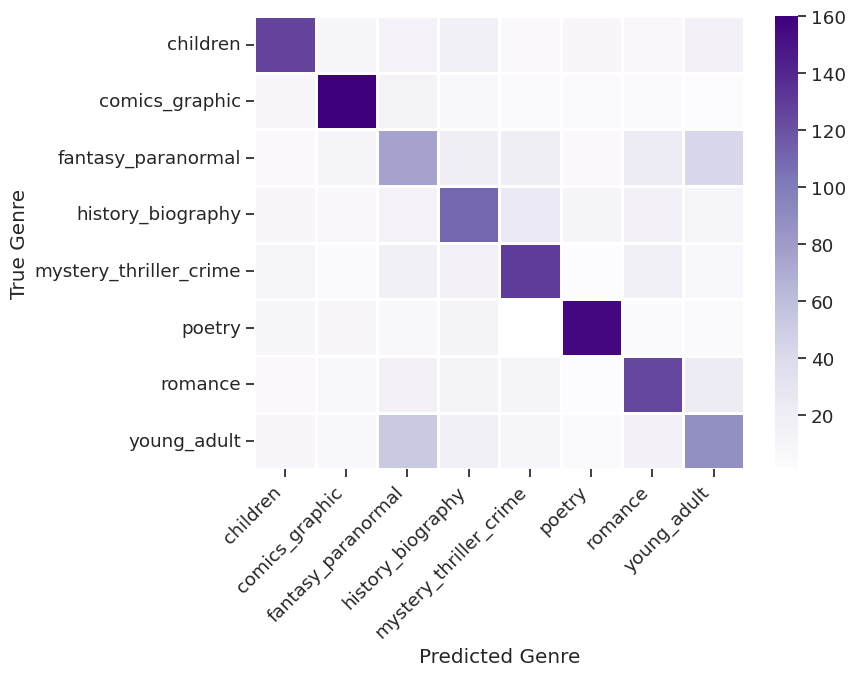

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looks good! We can see that overall, our model is assigning the correct labels for each genre.

Now, let's remove the diagonal from the plot to highlight the misclassifications.

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
    genre_classifications_dict[(_true_label, _predicted_label)] += 1

dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre',
                                 columns='Predicted Genre',
                                 values='Number of Classifications')

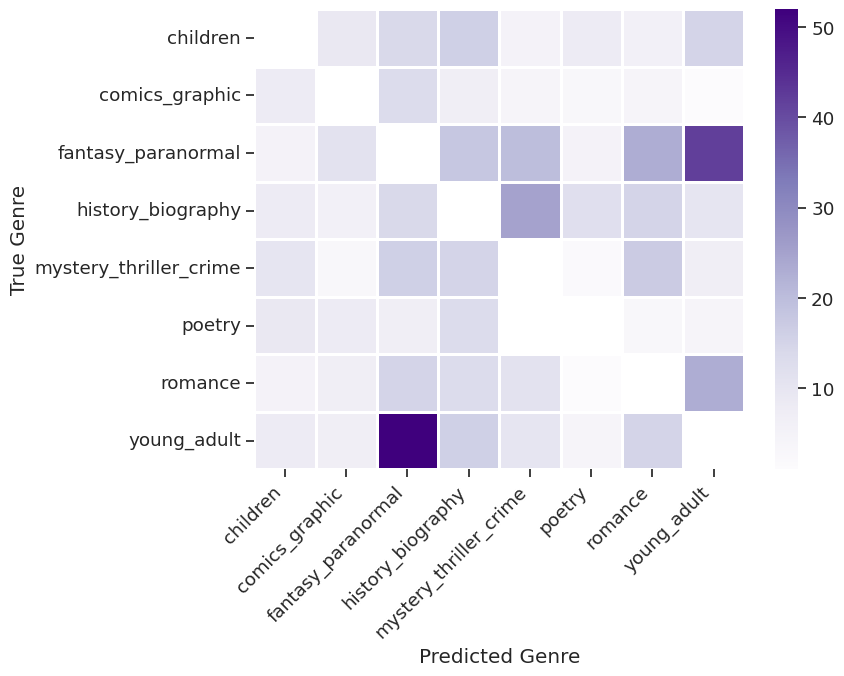

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()